In [1]:
using JLD
using Dates
using PyPlot
using Statistics: mean
using LinearAlgebra: norm

mr  = include("../../Tools/Model_Reduction_Dev.jl")
at  = include("../../Tools/AnalysisToolbox.jl")
kmr = include("KSE_modredTools.jl")

Unable to init server: Could not connect: Connection refused
Unable to init server: Could not connect: Connection refused

(.:13451): Gdk-CRITICAL **: 14:58:21.923: gdk_cursor_new_for_display: assertion 'GDK_IS_DISPLAY (display)' failed

(.:13451): Gdk-CRITICAL **: 14:58:21.927: gdk_cursor_new_for_display: assertion 'GDK_IS_DISPLAY (display)' failed


Main.KSE_modredTools

### Load and save information

In [2]:
server = startswith(pwd(), "/u5/jaredm") ? true : false
println("on server = $server")
# sol_file = server ? "../../../data/KSE_Data/KSE_sol$Exp.jld" :
#    "Examples/KSE/Data/KSE_sol$Exp.jld"
# println("Sol save location: " * sol_file)
# wf_file = server ? "../../../data/KSE_Data/KSE_wf$Exp-Mo$M_out.jld" :
#    "Examples/KSE/Data/KSE_wf$Exp-Mo$M_out.jld"

# When I want the standard lin et al. (2017) data.
sol_file = server ? "../../../data/KSE_Data/KSE_sol_linn.jld" :
   "Data/KSE_sol_linn.jld"

on server = true


"../../../data/KSE_Data/KSE_sol_linn.jld"

## Load data

In [4]:
@time Data = load(sol_file)
print("Data Loaded")
uu = Data["dat_uu"]
vv = Data["dat_vv"]
tt = Data["dat_tt"]

obs_gap = Data["obs_gap"]
h       = Data["h"]
P      = Data["P"]
N      = Data["N"]
d = 5

  5.130288 seconds (18.47 M allocations: 1.969 GiB, 6.93% gc time)
Data Loaded

5

In [5]:
M_out = 100
Δt = h*obs_gap

par = 1500
nfft = 2^12

Psi(x) = kmr.PSI(x; h, obs_gap, P, N)

Psi (generic function with 1 method)

## Get observations

In [6]:
X = vv[2:d+1, 1:end]

5×500001 Array{Complex{Float64},2}:
   0.312519+0.0376706im    0.319701+0.0460596im  …   0.270115-0.523138im
  -0.944952+0.876568im    -0.951524+0.871918im       0.272794+0.115175im
    1.63705+1.20801im       1.65154+1.24755im       -0.321451+0.00567049im
  -0.880294+0.0985232im   -0.866203+0.0937057im      0.902827-0.88528im
 -0.0130653+0.118098im   -0.0173149+0.129443im       0.181263-0.352839im

## Get Wiener Filter

In [7]:
@time h_wf = mr.get_wf(X, Psi; M_out, par, nfft, rl = false, PI = false)

Number of CKMS iterations: 6103
errK errR : 8.148016231247954e-11 4.512741213213582e-14
443.001022 seconds (169.25 M allocations: 773.837 GiB, 9.24% gc time)
638.016401 seconds (411.02 M allocations: 861.092 GiB, 7.45% gc time)


5×25×100 Array{Complex{Float64},3}:
[:, :, 1] =
  10545.7-794.949im   232.383+1179.6im   …  -20.1252-10.494im
  593.575-1799.06im   12685.9-1111.27im     -11.8238-10.7905im
 -911.765+3735.54im   200.106-1160.23im      39.9278-27.5552im
  57.7441-42.4492im  -398.934-200.039im      3.85142-38.91im
 -206.186+274.822im   14.6174-47.9232im     -9.89727+27.9757im

[:, :, 2] =
 -923.329+1049.9im   -257.06+35.9999im  …   43.9612+30.9441im
 -1283.12-2704.16im   881.87+2394.12im      24.7885+17.2973im
 -2448.36+2692.45im  36.5887-23.7307im     -103.841+26.8297im
  394.477+678.363im  -466.74+11.9714im     -18.2804+86.1575im
  110.848-135.379im  34.0694+22.3472im      27.7382-74.3678im

[:, :, 3] =
 -8715.85+832.049im   137.084-1023.18im  …  -22.6788-21.6486im
  1215.29+743.874im  -11344.4-356.744im     -5.70314-1.44347im
  453.665-2426.23im  -353.878+562.911im      74.4533+14.1772im
  293.217+391.919im   -293.16+443.571im      22.2058-48.2931im
  192.215-271.336im  -12.0341+29.414im      -21.1788

#### Little test

In [3]:
sig  = X[:,2:end];
pred = mr.get_pred(X[:,1:end-1], Psi);

sig_m  = mean(sig, dims = 2);
pred_m = mean(pred, dims = 2);

LoadError: UndefVarError: X not defined

In [8]:
C = sig_m

5×1 Array{Complex{Float64},2}:
  0.005048645019956558 - 0.00831165665009651im
 -0.030724418698244247 + 0.006908214772462476im
  0.002664331526325501 - 0.005653492362382936im
   8.61975383366236e-5 + 0.009133344816427328im
 -0.004065548006056918 - 0.0012582349896288782im

In [9]:
sig_rm = sum(h_wf[:,:,k]*pred[:,M_out - k + 1] for k = 1:M_out) + C

5×1 Array{Complex{Float64},2}:
 -0.7584377008344022 + 0.545959330544167im
 -2.5093173216375417 - 0.4794587153045355im
 -1.2042673866868232 + 1.9979411760263597im
  0.5927816580964818 - 1.001034298386383im
 -0.8079893286019948 + 0.4752459338696251im

In [10]:
sig[:,M_out-1:M_out+1]

5×3 Array{Complex{Float64},2}:
 -0.773311+0.173412im  -0.788864+0.16922im   -0.802887+0.163929im
  -2.20948+0.118773im    -2.2492+0.114701im   -2.28644+0.111559im
  0.103268+2.3945im    0.0604577+2.31926im   0.0185105+2.24313im
 -0.226919-0.584584im  -0.210921-0.652643im  -0.193203-0.72159im
 -0.660801+0.331298im   -0.62976+0.325305im  -0.595921+0.319447im

In [11]:
norm(sig_rm - sig[:,M_out])

1.7572369920742643

In [12]:
norm(sig_rm - sig[:,M_out])/norm(sig[:,M_out])

0.505620260737309

# Run Reduced model

## Find Cut off

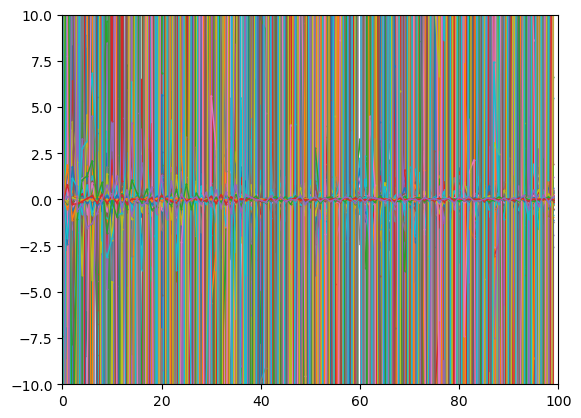

C:\Users\jared\.julia\conda\3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\jared\.julia\conda\3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\jared\.julia\conda\3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\jared\.julia\conda\3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\jared\.julia\conda\3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [11]:
for i = 1:5
    for j = 1:25
        plot(h_wf[i,j,:],".-",lw = 1,ms = 1)
        axis([0,100,-10,10])
    end
end

